## Transferring Autoencoder Encodings for MNIST Dataset

#### How easy is it to pass encodings between autoencoders?

### Simple Autoencoders
Lets' test on a two-layer autoencoder first.

In [1]:
# Simple Autoencoder.
# Architecture from https://blog.keras.io/building-autoencoders-in-keras.html

from keras.layers import Input, Dense
from keras.models import Model, Sequential

image_pixels = 784
encoding_dim = 32

encoder_input = Input(shape=(image_pixels,))
encoder_layer1 = Dense(encoding_dim, activation='relu', name = 'encoder_layer1')(encoder_input)

decoder_input = Input(shape=(encoding_dim,))
decoder_layer1 = Dense(image_pixels, activation='sigmoid', name = 'decoder_layer1')(decoder_input)

encoder = Model(input=encoder_input, output=encoder_layer1)

decoder = Model(input=decoder_input, output=decoder_layer1)

encoder.compile(optimizer='adadelta', loss='binary_crossentropy')
decoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Using Theano backend.


In [2]:
autoencoder = Model(input = encoder_input, output = decoder(encoder(encoder_input)))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [3]:
from keras.datasets import mnist
import numpy as np
(X_train, _), (X_test, _) = mnist.load_data()

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
print X_train.shape
print X_test.shape

(60000, 784)
(10000, 784)


In [4]:
# training the autoencoder:
autoencoder.fit(X_train, X_train, \
                nb_epoch=50, \
                batch_size=256, \
                shuffle=True, \
                validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s - loss: 0.3805 - val_loss: 0.2728
Epoch 2/50
60000/60000 [==============================] - 3s - loss: 0.2664 - val_loss: 0.2569
Epoch 3/50
60000/60000 [==============================] - 3s - loss: 0.2467 - val_loss: 0.2335
Epoch 4/50
60000/60000 [==============================] - 3s - loss: 0.2251 - val_loss: 0.2144
Epoch 5/50
60000/60000 [==============================] - 3s - loss: 0.2088 - val_loss: 0.2005
Epoch 6/50
60000/60000 [==============================] - 3s - loss: 0.1968 - val_loss: 0.1902
Epoch 7/50
60000/60000 [==============================] - 3s - loss: 0.1875 - val_loss: 0.1821
Epoch 8/50
60000/60000 [==============================] - 3s - loss: 0.1802 - val_loss: 0.1756
Epoch 9/50
60000/60000 [==============================] - 3s - loss: 0.1742 - val_loss: 0.1700
Epoch 10/50
60000/60000 [==============================] - 3s - loss: 0.1690 - val_loss: 0.1653

Early on I had an issue where 'autoencoder' had learned weights 
but they were not shared with 'encoder' and 'decoder'. 
Compiling 'encoder' and 'decoder' first and then using them to define 'autoencoder' 
seems to have fixed this, as seen in the quick check below.

In [161]:
# The weights match!!!! WOOO!!!
print "Sample decoder weight from decoder model  : " + str(decoder.get_weights()[0][0][0])
print "Sample decoder weight from autoencoder    : " + str(autoencoder.get_weights()[2][0][0])
print "Sample encoder weight from encoder model  : " + str(encoder.get_weights()[0][0][0])
print "Sample encoder weight from autoencoder    : " + str(autoencoder.get_weights()[0][0][0])

Sample decoder weight from decoder model  : -0.00290195
Sample decoder weight from autoencoder    : -0.00290195
Sample encoder weight from encoder model  : -0.0167069
Sample encoder weight from autoencoder    : -0.0167069


In [6]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)
autoencoder_reconstructed_imgs = autoencoder.predict(X_test)

Below, I am visually verifying everything is working as expected. <br><br> 
In particular, I want to make sure 'decoded_imgs', (images from applying 'decoder' to 'encoded_imgs') matches 'autoencoder_reconstructed_imgs', (images from applying 'autoencoder' to X_test directly).<br><br> 
Back before weight-sharing was working, 'decoded_imgs' looked like random noise because  'encoder' and 'decoder' did not update their parameters when 'autoencoder' was trained.

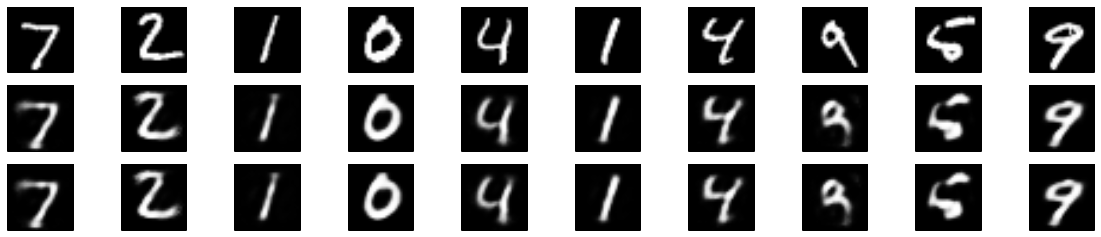

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(autoencoder_reconstructed_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [169]:
# Visually the encodings look like they match pretty closely.
# Let's verify that the encodings they match exactly.

diff = decoded_imgs[0] - autoencoder_reconstructed_imgs[0]
# Does the norm of the diff equal zero? If so, everything worked correctly.
diff.dot(diff)

0.0

In [170]:
# Let's make a function for instantiating the "Simple autocoder" 
# with the architecture described here 
#    https://blog.keras.io/building-autoencoders-in-keras.html.

from keras.layers import Input, Dense
from keras.models import Model, Sequential

def create_autoencoder(image_pixels, encoding_dim, model_id):
    i = model_id

    encoder_input = Input(shape=(image_pixels,))
    encoder_layer1 = Dense(encoding_dim, \
                           activation='relu', \
                           name = 'model' + str(i) + '_encoder_layer1')(encoder_input)

    decoder_input = Input(shape=(encoding_dim,))
    decoder_layer1 = Dense(image_pixels, \
                           activation='sigmoid', \
                           name = 'model' + str(i) + '_decoder_layer1')(decoder_input)

    encoder = Model(input=encoder_input, output=encoder_layer1)

    decoder = Model(input=decoder_input, output=decoder_layer1)

    encoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    decoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    
    autoencoder = Model(input = encoder_input, output = decoder(encoder(encoder_input)))

    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    
    return (encoder, decoder, autoencoder)

In [9]:
(e2, d2, a2) = create_autoencoder(784, 32, 2)

In [28]:
# Make a function to train autoencoders. 
# Not at all necessary, but it looks a bit cleaner, especially when using the default params.
def autoencoder_train(autoencoder, X_train, X_val, nr_epoch=50, batch_size=256):
    autoencoder.fit(X_train, X_train, \
                nb_epoch=nb_epoch, \
                batch_size=batch_size, \
                shuffle=True, \
                validation_data=(X_val, X_val))
    
    return 

In [12]:
autoencoder_train(a2, X_train, X_test)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s - loss: 0.3728 - val_loss: 0.2728
Epoch 2/50
60000/60000 [==============================] - 3s - loss: 0.2665 - val_loss: 0.2569
Epoch 3/50
60000/60000 [==============================] - 3s - loss: 0.2465 - val_loss: 0.2337
Epoch 4/50
60000/60000 [==============================] - 3s - loss: 0.2252 - val_loss: 0.2141
Epoch 5/50
60000/60000 [==============================] - 3s - loss: 0.2080 - val_loss: 0.1996
Epoch 6/50
60000/60000 [==============================] - 3s - loss: 0.1959 - val_loss: 0.1899
Epoch 7/50
60000/60000 [==============================] - 3s - loss: 0.1875 - val_loss: 0.1826
Epoch 8/50
60000/60000 [==============================] - 3s - loss: 0.1806 - val_loss: 0.1760
Epoch 9/50
60000/60000 [==============================] - 3s - loss: 0.1746 - val_loss: 0.1705
Epoch 10/50
60000/60000 [==============================] - 3s - loss: 0.1693 - val_loss: 0.1656

In [14]:
# Pass in encoder, decoder, autoencoder, and numpy array of images X.
def get_encodings_and_reconstructions(e, d, a, X):
    encoded_imgs = e.predict(X)
    decoded_imgs = d.predict(encoded_imgs)
    autoencoder_reconstructed_imgs = a.predict(X)
    
    # If we did everything right, encoded_imgs and autoencoder_reconstructed_imgs should match.
    return (encoded_imgs, decoded_imgs, autoencoder_reconstructed_imgs)

In [108]:
%matplotlib inline
import matplotlib.pyplot as plt

# n is how many digits we will display
def visualize(list_of_image_arrays, n=10):
    k = len(list_of_image_arrays)

    plt.figure(figsize=(20, 4))
    for j in range(n):
        for i in range(k):
            ax = plt.subplot(k, n, j + 1 + i * n)
            plt.imshow(list_of_image_arrays[i][j].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

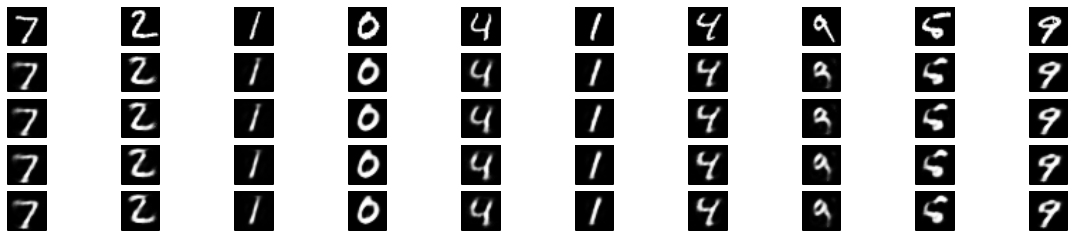

In [16]:
(e1_codes, d1_imgs, a1_imgs) = get_encodings_and_reconstructions(encoder, decoder, autoencoder, X_test)
(e2_codes, d2_imgs, a2_imgs) = get_encodings_and_reconstructions(e2, d2, a2, X_test)

visualize([X_test, d1_imgs, a1_imgs, d2_imgs, a2_imgs])

In [17]:
from sklearn import linear_model

clf = linear_model.LinearRegression()

# Multivariate multiple linear regression to map neural codes from e1 to e2.
clf.fit(e1_codes, e2_codes)

LinearRegression(copy_X=True, fit_intercept=True, normalize=False)

In [18]:
# Map all e1 encodings to the space for the a2 autoencoder's e2 encodings.
e12_codes = clf.predict(e1_codes)

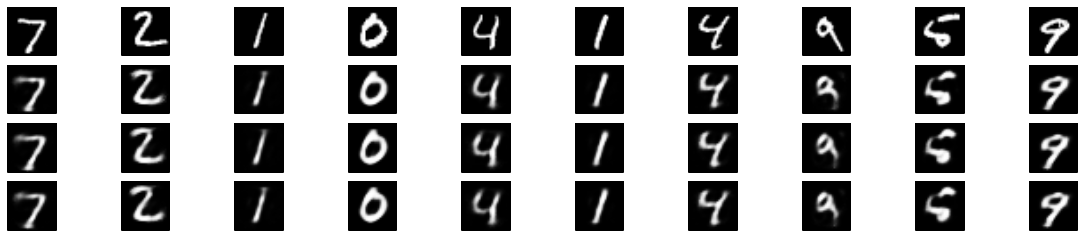

In [174]:
d2_imgs_from_e12_codes = d2.predict(e12_codes)

visualize([X_test, \
           d1_imgs, \
           d2_imgs, \
           d2_imgs_from_e12_codes])

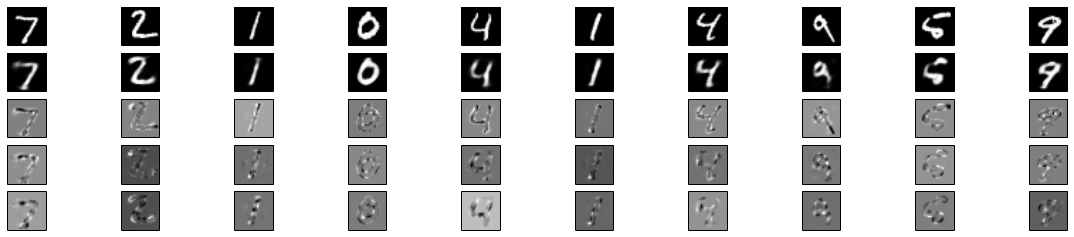

0.0123680345627 0.0127076787007 0.0137943375331 0.00140016067598 0.0011323516814


In [180]:
# Diffs of e1-d2 images against original images, e2-d2 images, and e1-d1 images.

# This seems to suggest that the encoder 
visualize([X_test, \
           d2_imgs_from_e12_codes, \
           d2_imgs_from_e12_codes - X_test, \
           d2_imgs_from_e12_codes - d1_imgs, \
           d2_imgs_from_e12_codes - d2_imgs])

from sklearn.metrics import mean_squared_error
e1d1_vs_originals = mean_squared_error(d1_imgs, X_test)
e2d2_vs_originals = mean_squared_error(d2_imgs, X_test)
e1d2_vs_originals = mean_squared_error(d2_imgs_from_e12_codes, X_test)
e1d2_vs_e1d1 = mean_squared_error(d2_imgs_from_e12_codes, d1_imgs)
e1d2_vs_e2d2 = mean_squared_error(d2_imgs_from_e12_codes, d2_imgs)

print e1d1_vs_originals, e2d2_vs_originals, e1d2_vs_originals, e1d2_vs_e1d1, e1d2_vs_e2d2

# The diffs between e1-d2 and e2-d2 are smaller than 
# the diffs between e1-d2 and e1-d1, 
# and both diffs are an order of magnitude smaller 
# than the loss caused by encoding and decoding images to begin with.

### Deep Autoencoders

Let's test out the same kind of experiment, using Deep Autoencoders instead of shallow ones.

In [20]:
# Let's make a function for instantiating a Deep Autocoder
# with the architecture described here 
#    https://blog.keras.io/building-autoencoders-in-keras.html.

from keras.layers import Input, Dense
from keras.models import Model, Sequential

def create_deep_autoencoder(image_pixels, encoding_dim, model_id):
    i = model_id

    encoder_input = Input(shape=(image_pixels,))
    encoder_layer1 = Dense(encoding_dim * 4,  \
                           activation='relu', \
                           name = 'model' + str(i) + '_encoder_layer1')(encoder_input)
    encoder_layer2 = Dense(encoding_dim * 2,  \
                           activation='relu', \
                           name = 'model' + str(i) + '_encoder_layer2')(encoder_layer1)
    encoder_layer3 = Dense(encoding_dim, \
                           activation='relu', \
                           name = 'model' + str(i) + '_encoder_layer3')(encoder_layer2)

    decoder_input = Input(shape=(encoding_dim,))
    decoder_layer1 = Dense(encoding_dim * 2,  \
                           activation='relu', \
                           name = 'model' + str(i) + '_decoder_layer1')(decoder_input)
    decoder_layer2 = Dense(encoding_dim * 4,  \
                           activation='relu', \
                           name = 'model' + str(i) + '_decoder_layer2')(decoder_layer1)
    decoder_layer3 = Dense(image_pixels, \
                           activation='sigmoid', \
                           name = 'model' + str(i) + '_decoder_layer3')(decoder_layer2)

    encoder = Model(input=encoder_input, output=encoder_layer3)

    decoder = Model(input=decoder_input, output=decoder_layer3)

    encoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    decoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    
    autoencoder = Model(input = encoder_input, output = decoder(encoder(encoder_input)))

    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    
    return (encoder, decoder, autoencoder)

In [21]:
(deep_e1, deep_d1, deep_a1) = create_deep_autoencoder(784, 32, "Deep1")
(deep_e2, deep_d2, deep_a2) = create_deep_autoencoder(784, 32, "Deep2")

In [22]:
autoencoder_train(deep_a1, X_train, X_test, nb_epoch=100)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s - loss: 0.3502 - val_loss: 0.2646
Epoch 2/50
60000/60000 [==============================] - 4s - loss: 0.2604 - val_loss: 0.2552
Epoch 3/50
60000/60000 [==============================] - 4s - loss: 0.2449 - val_loss: 0.2324
Epoch 4/50
60000/60000 [==============================] - 4s - loss: 0.2227 - val_loss: 0.2122
Epoch 5/50
60000/60000 [==============================] - 4s - loss: 0.2061 - val_loss: 0.1996
Epoch 6/50
60000/60000 [==============================] - 4s - loss: 0.1966 - val_loss: 0.1934
Epoch 7/50
60000/60000 [==============================] - 4s - loss: 0.1887 - val_loss: 0.1833
Epoch 8/50
60000/60000 [==============================] - 4s - loss: 0.1812 - val_loss: 0.1760
Epoch 9/50
60000/60000 [==============================] - 4s - loss: 0.1741 - val_loss: 0.1710
Epoch 10/50
60000/60000 [==============================] - 4s - loss: 0.1692 - val_loss: 0.1659

In [23]:
autoencoder_train(deep_a2, X_train, X_test, nb_epoch=100)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s - loss: 0.3669 - val_loss: 0.2650
Epoch 2/50
60000/60000 [==============================] - 4s - loss: 0.2582 - val_loss: 0.2503
Epoch 3/50
60000/60000 [==============================] - 4s - loss: 0.2429 - val_loss: 0.2338
Epoch 4/50
60000/60000 [==============================] - 4s - loss: 0.2276 - val_loss: 0.2195
Epoch 5/50
60000/60000 [==============================] - 4s - loss: 0.2154 - val_loss: 0.2100
Epoch 6/50
60000/60000 [==============================] - 4s - loss: 0.2070 - val_loss: 0.2007
Epoch 7/50
60000/60000 [==============================] - 4s - loss: 0.1970 - val_loss: 0.1887
Epoch 8/50
60000/60000 [==============================] - 4s - loss: 0.1857 - val_loss: 0.1816
Epoch 9/50
60000/60000 [==============================] - 4s - loss: 0.1802 - val_loss: 0.1771
Epoch 10/50
60000/60000 [==============================] - 4s - loss: 0.1761 - val_loss: 0.1738

In [24]:
from sklearn import linear_model

def translate_neural_codes(model_e1_codes, model_e2_codes):
    lm = linear_model.LinearRegression()

    # Multivariate multiple linear regression to map neural codes from e1 to e2.
    lm.fit(model_e1_codes, model_e2_codes)
    
    return lm

Now let's generate the encodings and decoded images for both of the two deep autoencoders.

In [182]:
(deep_e1_codes, deep_d1_imgs, deep_a1_imgs) = get_encodings_and_reconstructions(deep_e1, deep_d1, deep_a1, X_test)
(deep_e2_codes, deep_d2_imgs, deep_a2_imgs) = get_encodings_and_reconstructions(deep_e2, deep_d2, deep_a2, X_test)

Now let's learn the translation from the 'deep_e1' encodings to the 'deep_e2' encodings.

In [187]:
deep12_tr = translate_neural_codes(deep_e1_codes, deep_e2_codes)

Now let's use the mapping we just learned to get the translated encodings.

In [188]:
deep_e12_codes = deep12_tr.predict(deep_e1_codes)

Now let's decode the translated encodings back into images using 'deep_d2'

In [ ]:
deep_d2_imgs_from_deep_e12_codes = deep_d2.predict(deep_e12_codes)

Now let's visualize the original images, the e1-d1 images, the e2-d2 images, and the e1-e2-d2 images.

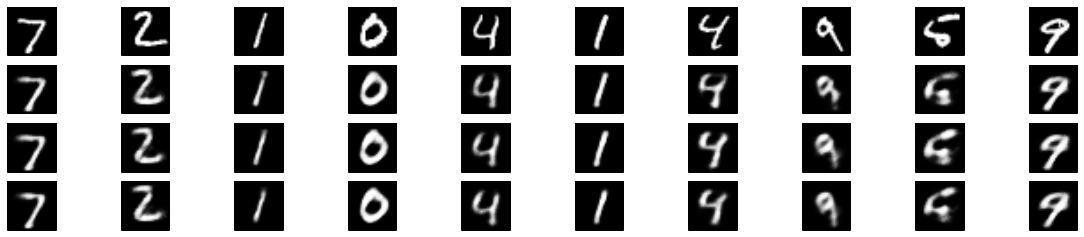

In [189]:
visualize([X_test, deep_d1_imgs, deep_d2_imgs, deep_d2_imgs_from_deep_e12_codes])

In case anyone was wondering, the autoencoders don't match or anything!
Here, let's take the e1 encodings and decode them using d2, *without* translating them to e2 codes first.<br>

Compare the second and third rows. The translation is everything.

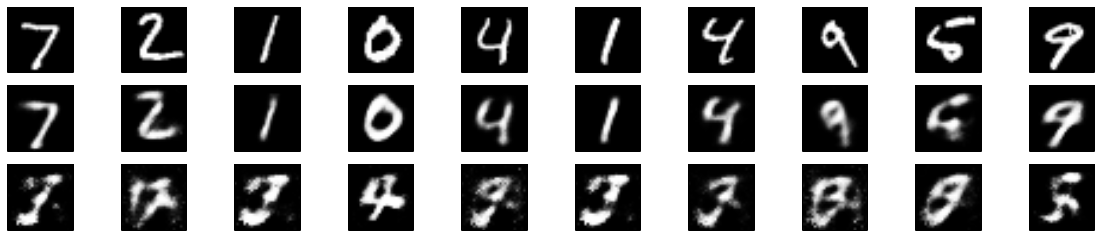

In [191]:
nonsense = deep_d2.predict(deep_e1_codes)
visualize([X_test, deep_d2_imgs_from_deep_e12_codes, nonsense])
# Compare the second and third rows. The translation is everything.

In [192]:
deep12_tr.coef_

array([[  7.97422140e+04,   2.44364812e-01,   3.39594164e-01, ...,
         -1.15357426e-01,  -4.74566102e-01,  -1.71087163e+05],
       [  1.04999900e+06,  -4.05723446e-01,   1.54974891e-01, ...,
          1.69635681e-01,   2.94739654e-01,  -2.45347764e+05],
       [ -9.18569738e+05,   2.57350790e-01,  -1.48459382e-02, ...,
          8.11476586e-03,  -1.81954455e-01,  -8.68930569e+05],
       ..., 
       [ -1.07319671e+06,  -3.08950288e-01,  -1.94937932e-02, ...,
         -8.60312490e-02,   2.03471326e-01,  -3.84633800e+05],
       [  3.03780845e+05,   3.60662197e-01,  -6.14082741e-03, ...,
         -2.21094088e-01,  -1.05696198e-01,  -1.34540274e+05],
       [ -6.99313685e+05,  -5.15925230e-01,  -1.29404607e-01, ...,
          6.11372047e-01,   1.32688917e-01,   8.63301350e+05]])

### Sparse Coding
<br>
We have learned a mapping from one space of encodings to another.
However, as hypothesized by Karol Gregor and Yann Lecun in their 2010 paper, 
autoencoders appear to do some kind of sparse coding.<br>
<br>
If the components for this sparse coding are overcomplete, 
then learning a linear mapping on the the raw encodings might be a suboptimal choice.<br><br>
If we could first infer sparse codes for the original dense encodings, 
we could potentially apply a linear mapping on those sparse codes, 
and then translate the data back to its dense form after applying the map.<br>
<br>
First we need to do dictionary learning using Orthogonal Matching Persuit and LARS.<br>
(The training for this part may need some fine-tuning... We'll see.)

In [29]:
from sklearn.decomposition import MiniBatchDictionaryLearning, DictionaryLearning

In [82]:
dlm_a1 = MiniBatchDictionaryLearning(n_components = 64, \
                                     verbose = True, \
                                     n_jobs = 3, \
                                     n_iter = 300, \
                                     transform_n_nonzero_coefs = 5)

dlm_a1.fit(deep_e1_codes)

[dict_learning] .+++++++++++++++++++++++++++++++++++++++.++++++++.++.+.+.......................................................................................................................................................................................................................................................................................................

MiniBatchDictionaryLearning(alpha=1, batch_size=3, dict_init=None,
              fit_algorithm='lars', n_components=64, n_iter=300, n_jobs=3,
              random_state=None, shuffle=True, split_sign=False,
              transform_algorithm='omp', transform_alpha=None,
              transform_n_nonzero_coefs=5, verbose=True)

In [83]:
sparse_coding_deep_e1_codes = dlm_a1.transform(deep_e1_codes)

In [84]:
dlm_a2 = decomposition.MiniBatchDictionaryLearning(n_components = 64, \
                                                   verbose = True, \
                                                   n_jobs = 3, \
                                                   n_iter = 300, \
                                                   transform_n_nonzero_coefs = 5)
dlm_a2.fit(deep_e2_codes)

[dict_learning] .+++++++++++++++++++++++++++++++++++++.++++++++.+++.........................................................................................................................................................................................................................................................................................................

MiniBatchDictionaryLearning(alpha=1, batch_size=3, dict_init=None,
              fit_algorithm='lars', n_components=64, n_iter=300, n_jobs=3,
              random_state=None, shuffle=True, split_sign=False,
              transform_algorithm='omp', transform_alpha=None,
              transform_n_nonzero_coefs=5, verbose=True)

In [85]:
sparse_coding_deep_e2_codes = dlm_a2.transform(deep_e2_codes)

In [86]:
sparse_coding_deep_e2_codes[0]

array([  0.        ,   0.        ,  42.38646347,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
       -13.876012  ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
        10.6895051 ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   6.76037677,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,  -5.67363906,   0.        ,   0.  

In [87]:
dml_a1_dictionary = dlm_a1.components_
dml_a2_dictionary = dlm_a2.components_

In [111]:
d2_all_atoms_viz = deep_d2.predict(np.array(dml_a2_dictionary))

The sparse code components look pretty low-quality when visualized individually.
I need to look into this more. Something seems off. 
I had a similar problem with PCA on MNIST a few years back, and I fixed it... somehow.<br><br>

In any case, there are still some encouraging results to present later.

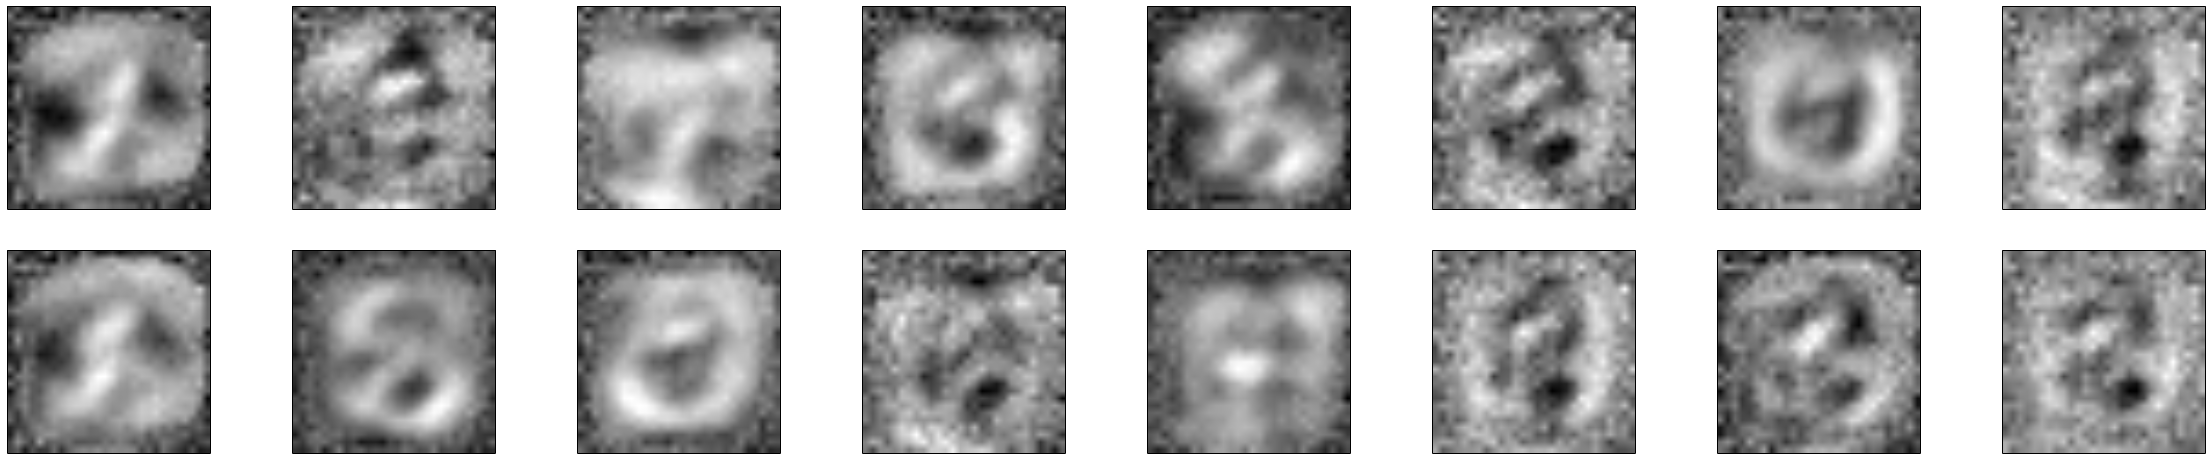

In [112]:
visualize([d2_all_atoms_viz[0:8], \
           d2_all_atoms_viz[8:16], \
          ], n = 8, x = 40, y = 8)

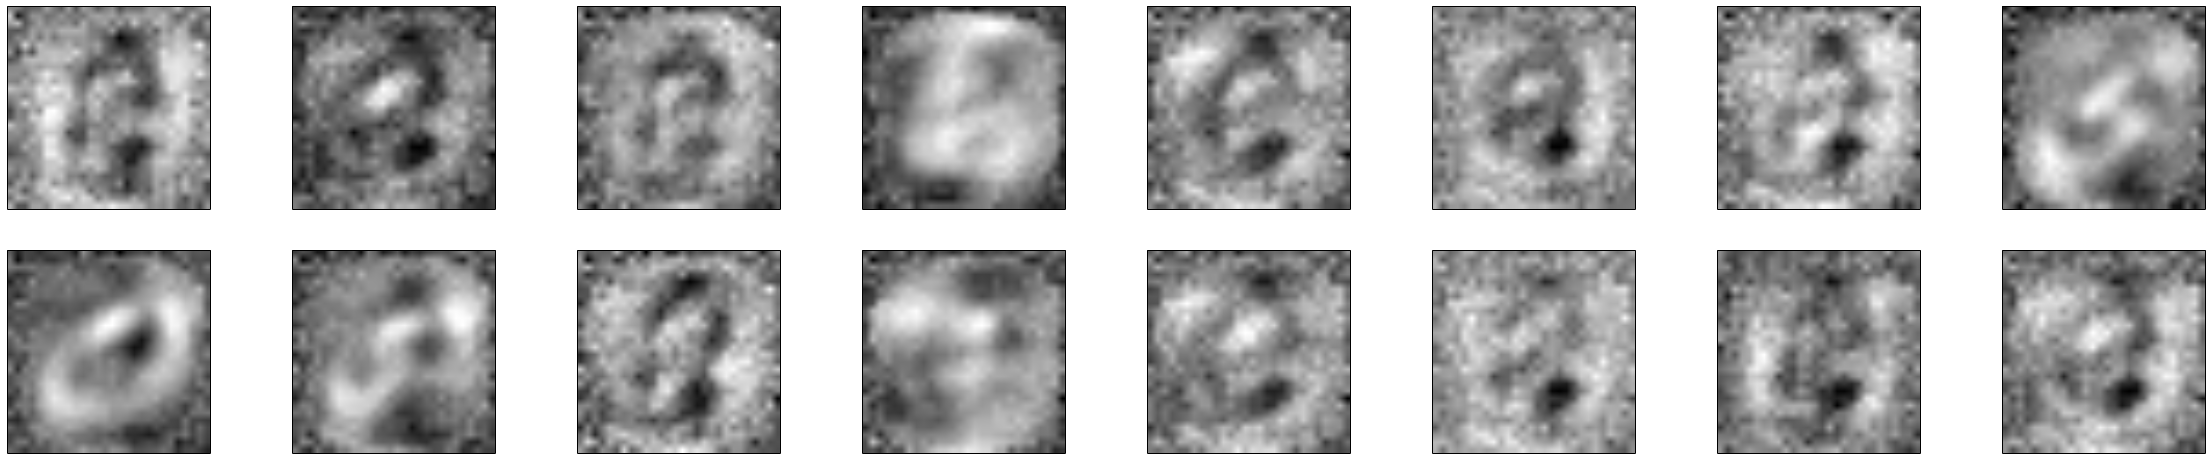

In [113]:
visualize([d2_all_atoms_viz[16:24], \
           d2_all_atoms_viz[24:32], \
          ], n = 8, x = 40, y = 8)

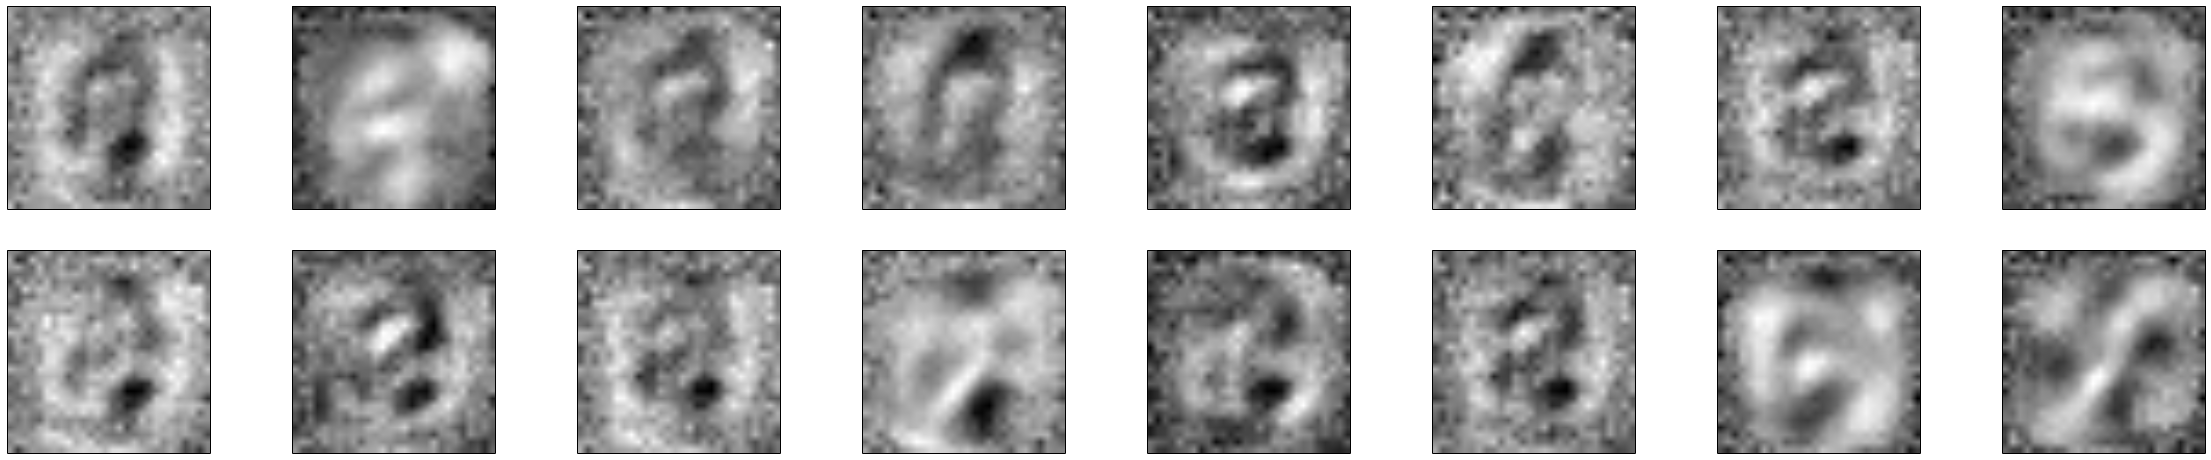

In [114]:
visualize([d2_all_atoms_viz[32:40], \
           d2_all_atoms_viz[40:48], \
          ], n = 8, x = 40, y = 8)

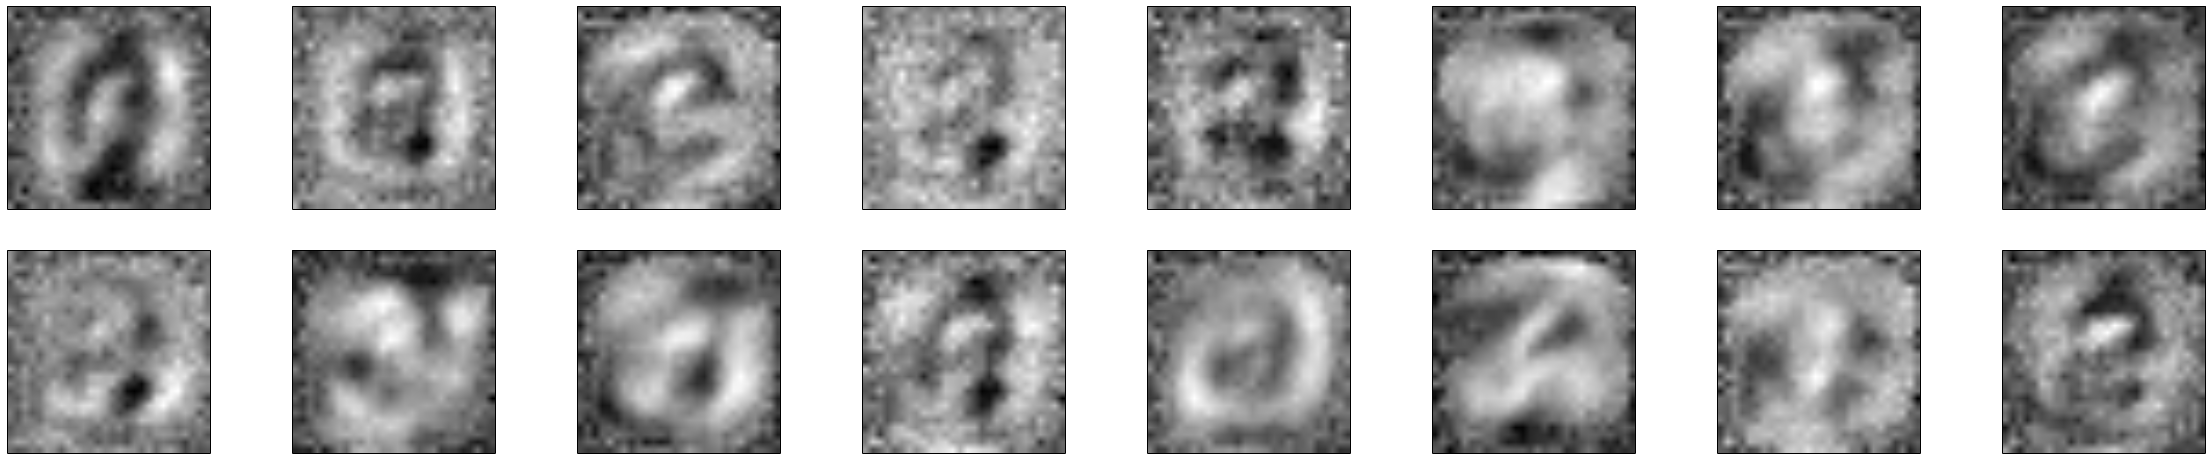

In [115]:
visualize([d2_all_atoms_viz[48:56], \
           d2_all_atoms_viz[56:64], \
          ], n = 8, x = 40, y = 8)

In [116]:
clf = linear_model.LinearRegression()


In [120]:
clf.fit(sparse_coding_deep_e1_codes, sparse_coding_deep_e2_codes)

LinearRegression(copy_X=True, fit_intercept=True, normalize=False)

In [122]:
sparse_coding_deep_e2_codes_from_transform = clf.predict(sparse_coding_deep_e1_codes)

In [195]:
example_transformed_sparse_code = sparse_coding_deep_e2_codes_from_transform[0]
example_transformed_sparse_code.dot(dml_a2_dictionary)

array([  9.16885784e+00,   7.20283426e+00,   7.07642750e+00,
        -2.20196478e-02,  -2.35466103e-02,   2.39283894e+00,
         1.00737233e+01,   8.48238204e+00,   9.87674156e-01,
         2.74835520e+00,   1.05357878e+01,   1.29163650e+01,
         1.07221130e+01,   6.09022053e+00,  -4.79594036e-02,
         2.49002153e+00,   1.21984391e+01,   5.43401429e+00,
         5.48061005e+00,  -1.69282943e-02,   8.37586658e-01,
         5.23626987e+00,   2.17145627e-02,   2.03740108e+01,
         7.98569064e+00,   5.49697498e+00,   2.06580212e+00,
         1.45998885e+01,   1.36397389e+01,   1.34234380e+01,
         3.69060243e+00,   3.25157680e+00])

In [194]:
# Very close values!!! (Compare this to above vector.)
deep_e2_codes[0]

array([  1.08681240e+01,   8.13858318e+00,   6.96353531e+00,
        -2.35158950e-08,  -6.96163625e-08,   1.63686335e+00,
         1.15884724e+01,   9.53736019e+00,   1.26184142e+00,
         2.24609709e+00,   1.14373798e+01,   1.19862394e+01,
         1.20931177e+01,   5.21334410e+00,   2.58442014e-08,
         3.69084954e+00,   1.12818222e+01,   7.75882912e+00,
         6.43806791e+00,  -7.71833584e-08,   8.98551941e-01,
         5.75020027e+00,   6.24568202e-08,   2.10442829e+01,
         6.73142767e+00,   4.72248745e+00,   2.41872835e+00,
         1.51501541e+01,   1.35515375e+01,   1.28614063e+01,
         2.29105926e+00,   4.23666716e+00])

In [143]:
import math 
diffs = (deep_e2_codes[0] - example_transformed_sparse_code.dot(dml_a2_dictionary))
math.sqrt(diffs.dot(diffs))

5.252316080874586

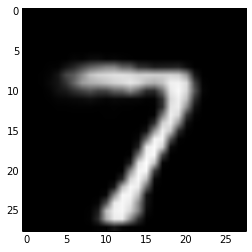

In [145]:
e2_d2_image_sample = deep_d2.predict(np.array([deep_e2_codes[0]]))
plt.imshow(e2_d2_image_sample.reshape(28,28))

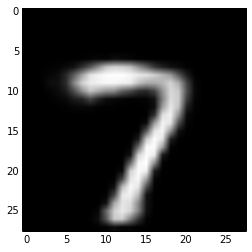

In [147]:
example_transformed_sparse_code = sparse_coding_deep_e2_codes_from_transform[0]
deep_e2_encoding_dense_from_deep_e1_sparsecoding_map = example_transformed_sparse_code.dot(dml_a2_dictionary)

e1_sc_d2_image_sample = deep_d2.predict(np.array([deep_e2_encoding_dense_from_deep_e1_sparsecoding_map]))
plt.imshow(e1_sc_d2_image_sample.reshape(28,28))

In [126]:
sparse_coding_deep_e1_codes[0]

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,  -5.5802086 ,
         0.        ,   0.        ,   0.        ,  30.60482193,
         0.        ,   6.2584283 ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
        -5.52567243,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,  -2.40117367,   0.  

In [127]:
sparse_coding_deep_e2_codes[0]

array([  0.        ,   0.        ,  42.38646347,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
       -13.876012  ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
        10.6895051 ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   6.76037677,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,  -5.67363906,   0.        ,   0.  

In [196]:
deep_e2d2_image_samples = deep_d2.predict(deep_e2_codes[0:10])

In [197]:
deep_e2_codes_from_e1_sc_e2_map = sparse_coding_deep_e2_codes_from_transform.dot(dml_a2_dictionary)

deep_e1d2_image_samples = deep_d2.predict(deep_e2_codes_from_e1_sc_e2_map)

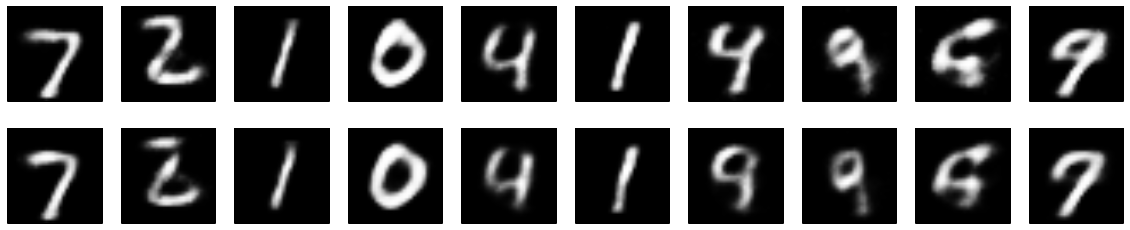

In [198]:
# Straight thru one autoencoder vs translated using sparse coding
visualize([deep_e2d2_image_samples, deep_e1d2_image_samples])

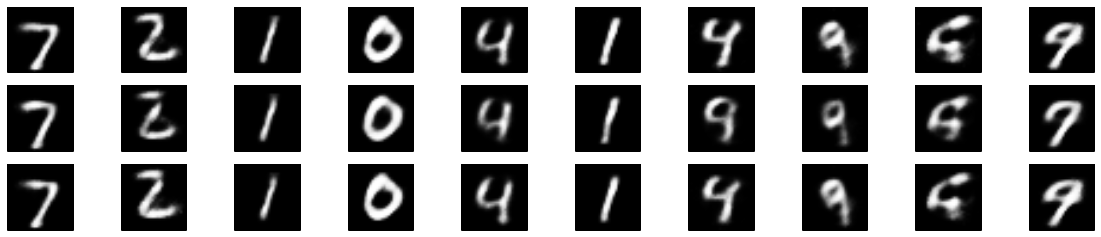

In [199]:

# as a reminder, earlier we had also defined some images
#   deep_d2_imgs_from_deep_e12_codes
# by using multivariate multiple linear regression 
# on the dense codes
# instead of doing sparse coding first
# 
# Let's visualize everything.

# Straight thru autoencoder a2, vs translated from sparse codes, vs translated densely
visualize([deep_e2d2_image_samples, deep_e1d2_image_samples, deep_d2_imgs_from_deep_e12_codes])

In [160]:
# As we can see, Sparse coding cost us something in some cases, 
# but helped with legibility in others.

# E.g., the "5" digit that is second from the right is very distorted 
# in the image that made using codes from the dense_e1 -> dense_e2 mapping (bottom row).

# On the other hand, the "4" digit in the 7th column is very distorted 
# in the image that was made using a dense_e1 -> sparse_e1 -> sparse_e2 -> dense_e2 mapping (middle row).

# Overall, Sparse Coding does not seem like it is a helpful assumption, even if it is not entirely wrong.
# Perhaps I imposed too much sparsity.

# I will continue to play around with this.